# 0 Additional requirements
Run this only once:

In [1]:
#run this code once, too
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# 1 Intro
In topic modeling with gensim (https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/), we followed a structured workflow to build an insightful topic model based on the Latent Dirichlet Allocation (LDA) algorithm.

In this post, we will build the topic model using gensim’s native LdaModel and explore multiple strategies to effectively visualize the results using matplotlib plots.

I will be using a portion of the 20 Newsgroups dataset since the focus is more on approaches to visualizing the results.

Let’s begin by importing the packages and the 20 News Groups dataset.

In [2]:
import sys
!{sys.executable} -m spacy download de
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('german')
stop_words.extend(['sagen', 'geben', 'gehen'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


     |████████████████████████████████| 14.9MB 17.1MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp37-none-any.whl size=14907057 sha256=81fe9e2c1f734a70320e9d711ce6a68d2fe5aa618481af6c80f585c2a91842c7
  Stored in directory: /tmp/pip-ephem-wheel-cache-mxjwsq24/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


# 2 Import NewsGroups Dataset
Let’s import the news groups dataset and retain only 4 of the target_names categories.

In [3]:
# Import Dataset
df = pd.read_json('https://files.ifi.uzh.ch/cl/siclemat/lehre/fs21/tm/data/all_de_topics.jsonl', lines=True,
nrows=5563)
print(df.shape)  #> (2361, 3)
df.head()

(5563, 2)


,content,target_names
0,"Ich bitte Sie namens der Minderheit, diese Mot...",FraktionderSchweizerischenVolkspartei
1,Die Kommission für Verkehr und Fernmeldewesen ...,FraktionderSchweizerischenVolkspartei
2,"Ich bitte Sie, in dieser Frage dem Weg der Kom...",FraktionderSchweizerischenVolkspartei
3,Der Missbrauch an der Marke Schweiz im In- und...,FraktionderSchweizerischenVolkspartei
4,Auch ich bin für Eintreten auf diese beiden Vo...,FraktionderSchweizerischenVolkspartei


# 3 Tokenize Sentences and Clean
Removing the emails, new line characters, single quotes and finally split the sentence into a list of words using gensim’s simple_preprocess(). Setting the deacc=True option removes punctuations.

In [4]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.content.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])
# [['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', ...trucated...]]

[['ich', 'bitte', 'sie', 'namens', 'der', 'minderheit', 'diese', 'motion', 'abzulehnen', 'naturlich', 'machen', 'wir', 'uns', 'keine', 'illusion', 'damit', 'im', 'rat', 'durchzukommen', 'vielmehr', 'wird', 'es', 'auf', 'absehbare', 'zeit', 'einmal', 'der', 'souveran', 'sein', 'der', 'grundsatzlich', 'festlegen', 'wird', 'wie', 'viele', 'auslandeinsatze', 'die', 'schweizer', 'armee', 'leisten', 'soll', 'sicher', 'kann', 'man', 'aus', 'dem', 'seinerzeitigen', 'volksentscheid', 'bei', 'der', 'letzten', 'revision', 'des', 'militargesetzes', 'nicht', 'einfach', 'schliessen', 'dass', 'der', 'souveran', 'scheibchenweise', 'nach', 'salamitaktik', 'immer', 'mehr', 'dieser', 'sehr', 'auslandeinsatze', 'gewollt', 'habe', 'ein', 'referendum', 'oder', 'eine', 'volksinitiative', 'soll', 'folglich', 'bei', 'sich', 'bietender', 'gelegenheit', 'dieses', 'thema', 'im', 'volk', 'wieder', 'einmal', 'grundsatzlich', 'zur', 'diskussion', 'stellen', 'fur', 'heute', 'mochte', 'ich', 'ihnen', 'einfach', 'ein',

# 4 Build the Bigram, Trigram Models and Lemmatize
Let’s form the bigram and trigrams using the Phrases model. This is passed to Phraser() for efficiency in speed of execution.

Next, lemmatize each word to its root form, keeping only nouns, adjectives, verbs and adverbs.

We keep only these POS tags because they are the ones contributing the most to the meaning of the sentences. Here, I use spacy for lemmatization.

In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [6]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('de', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

# 5 Build the Topic Model
To build the LDA topic model using LdaModel(), you need the corpus and the dictionary. Let’s create them first and then build the model. The trained topics (keywords and weights) are printed below as well.

If you examine the topic key words, they are nicely segregate and collectively represent the topics we initially chose: Christianity, Hockey, MidEast and Motorcycles. Nice!

In [7]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)
# id2word.filter_extremes(no_below=5, no_above=0.5, keep_n=4000)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
# can be adapted to 6 topics using num_topics = 6
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.022*"schweizer" + 0.014*"auslander" + 0.014*"produkte" + '
  '0.009*"auslandischen" + 0.007*"verkaufen" + 0.007*"erwerb" + 0.007*"opfer" '
  '+ 0.007*"verbieten" + 0.007*"auslanderinnen" + 0.006*"bauern"'),
 (1,
  '0.015*"konnen" + 0.015*"heute" + 0.013*"gut" + 0.012*"ja" + 0.011*"kommen" '
  '+ 0.011*"immer" + 0.010*"schon" + 0.009*"fragen" + 0.009*"ganz" + '
  '0.008*"eben"'),
 (2,
  '0.035*"prozent" + 0.020*"kosten" + 0.017*"hoch" + 0.011*"franken" + '
  '0.010*"jahr" + 0.010*"rund" + 0.009*"geld" + 0.008*"mussen" + '
  '0.008*"mittel" + 0.005*"fur"'),
 (3,
  '0.062*"initiative" + 0.012*"volk" + 0.010*"recht" + 0.008*"mussen" + '
  '0.008*"politisch" + 0.007*"volksinitiative" + 0.007*"entscheiden" + '
  '0.007*"damals" + 0.006*"gegenvorschlag" + 0.006*"grundsatz"'),
 (4,
  '0.026*"kommission" + 0.015*"antrag" + 0.013*"minderheit" + 0.012*"vorlage" '
  '+ 0.011*"artikel" + 0.011*"mehrheit" + 0.010*"deshalb" + 0.010*"kantone" + '
  '0.010*"folgen" + 0.009*"gesetz"'),
 (5,
  

# 6 What is the Dominant topic and its percentage contribution in each document
In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.

This way, you will know which document belongs predominantly to which topic.

In [8]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.2800,"konnen, heute, gut, ja, kommen, immer, schon, ...","[minderheit, motion, ablehnen, naturlich, illu..."
1,1,4.0,0.3233,"kommission, antrag, minderheit, vorlage, artik...","[kommission, fur, verkehr, fernmeldewesen, sit..."
2,2,1.0,0.4870,"konnen, heute, gut, ja, kommen, immer, schon, ...","[bitte, fragen, folgen, gleichen, vorweg, argu..."
3,3,1.0,0.3201,"konnen, heute, gut, ja, kommen, immer, schon, ...","[missbrauch, marke, ausland, gut, beraten, kos..."
4,4,1.0,0.6189,"konnen, heute, gut, ja, kommen, immer, schon, ...","[fur, eintreten, beiden_vorlagen, enthusiasmus..."
5,5,7.0,0.5272,"bundesrat, uber, motion, menschen, mussen, ber...","[verkauferin, franken, pension, vermogen, akti..."
6,6,4.0,0.3229,"kommission, antrag, minderheit, vorlage, artik...","[svp_fraktion, unterstutzt, eintreten, lehnen,..."
7,7,7.0,0.7675,"bundesrat, uber, motion, menschen, mussen, ber...","[stelle, forderung, bundesrat, umsetzung, uber..."
8,8,2.0,0.4724,"prozent, kosten, hoch, franken, jahr, rund, ge...","[svp_fraktion, unterstutzt, schlage, gemass, a..."
9,9,7.0,0.3649,"bundesrat, uber, motion, menschen, mussen, ber...","[stelle, antrag, demokratie, stolz, funktionie..."


In [9]:
df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == 1.0, "Text"]

0       [minderheit, motion, ablehnen, naturlich, illu...
2       [bitte, fragen, folgen, gleichen, vorweg, argu...
3       [missbrauch, marke, ausland, gut, beraten, kos...
4       [fur, eintreten, beiden_vorlagen, enthusiasmus...
10      [kolleginnen, kollegen, vorlage, zweifeln, ja,...
                              ...                        
5556    [herr, kollege, escher, auffordern, personlich...
5557    [bekennen, sogar, prasident, projekt, schickli...
5558    [herr, schweiger, votum, herausgefordert, leid...
5560    [system, warum, eigentlich, englische, ausdruc...
5561    [sp_fraktion, schliesst, mehrheit, lehnen, ant...
Name: Text, Length: 3842, dtype: object

# 7 The most representative sentence for each topic
Sometimes you want to get samples of sentences that most represent a given topic. This code gets the most exemplar sentence for each topic.

In [10]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.3986,"schweizer, auslander, produkte, auslandischen, verkaufen, erwerb, opfer, verbieten, auslanderinn...","[wann, milch, schweizerisch, artikel, gretchenfrage, minderheit, halten, eben, leben, milch, sch..."
1,1.0,0.7439,"konnen, heute, gut, ja, kommen, immer, schon, fragen, ganz, eben","[schweizerinnen, schweizer, krank, manchmal, daran, gut, nennen, stabilste, wahrung, welt, saal,..."
2,2.0,0.5058,"prozent, kosten, hoch, franken, jahr, rund, geld, mussen, mittel, fur","[uber, rechnung, abgelaufen, rechnungsjahr, finanzwirksamen, ausgaben, departementes, belaufen, ..."
3,3.0,0.3944,"initiative, volk, recht, mussen, politisch, volksinitiative, entscheiden, damals, gegenvorschlag...","[parlament, leben, vertrauen, volk, beruhen, gegenseitigkeit, vertrauen, volk, volk, vertrauen, ..."
4,4.0,0.6089,"kommission, antrag, minderheit, vorlage, artikel, mehrheit, deshalb, kantone, folgen, gesetz","[differenz, bleiben, missbrauchliche, allgemein, mehrheit, kommission, entscheiden, betreffen, s..."
5,5.0,0.4046,"mussen, bereich, wettbewerb, neue, markt, privat, zukunft, aufhebung, patienten, davon","[fange, forderungen, einfrieren, bundesrat, ende, jahr, verordnung, durchsetzen, netze, abschrei..."
6,6.0,0.3458,"armee, einsatz, erhohung, mann, ausgaben, aufgaben, budget, militarischen, entziehen, ausbildung","[sp_fraktion, fur, eintreten, ausgehen, vorstellung, armee, soldaten, risikobasierten, auftrag, ..."
7,7.0,0.7675,"bundesrat, uber, motion, menschen, mussen, bericht, weit, dabei, beantragen, thema","[stelle, forderung, bundesrat, umsetzung, uber, national, mechanismen, streitbeilegung, sicherst..."


# 8 Frequency Distribution of Word Counts in Documents
When working with a large number of documents, you want to know how big the documents are as a whole and by topic. Let’s plot the document word counts distribution.

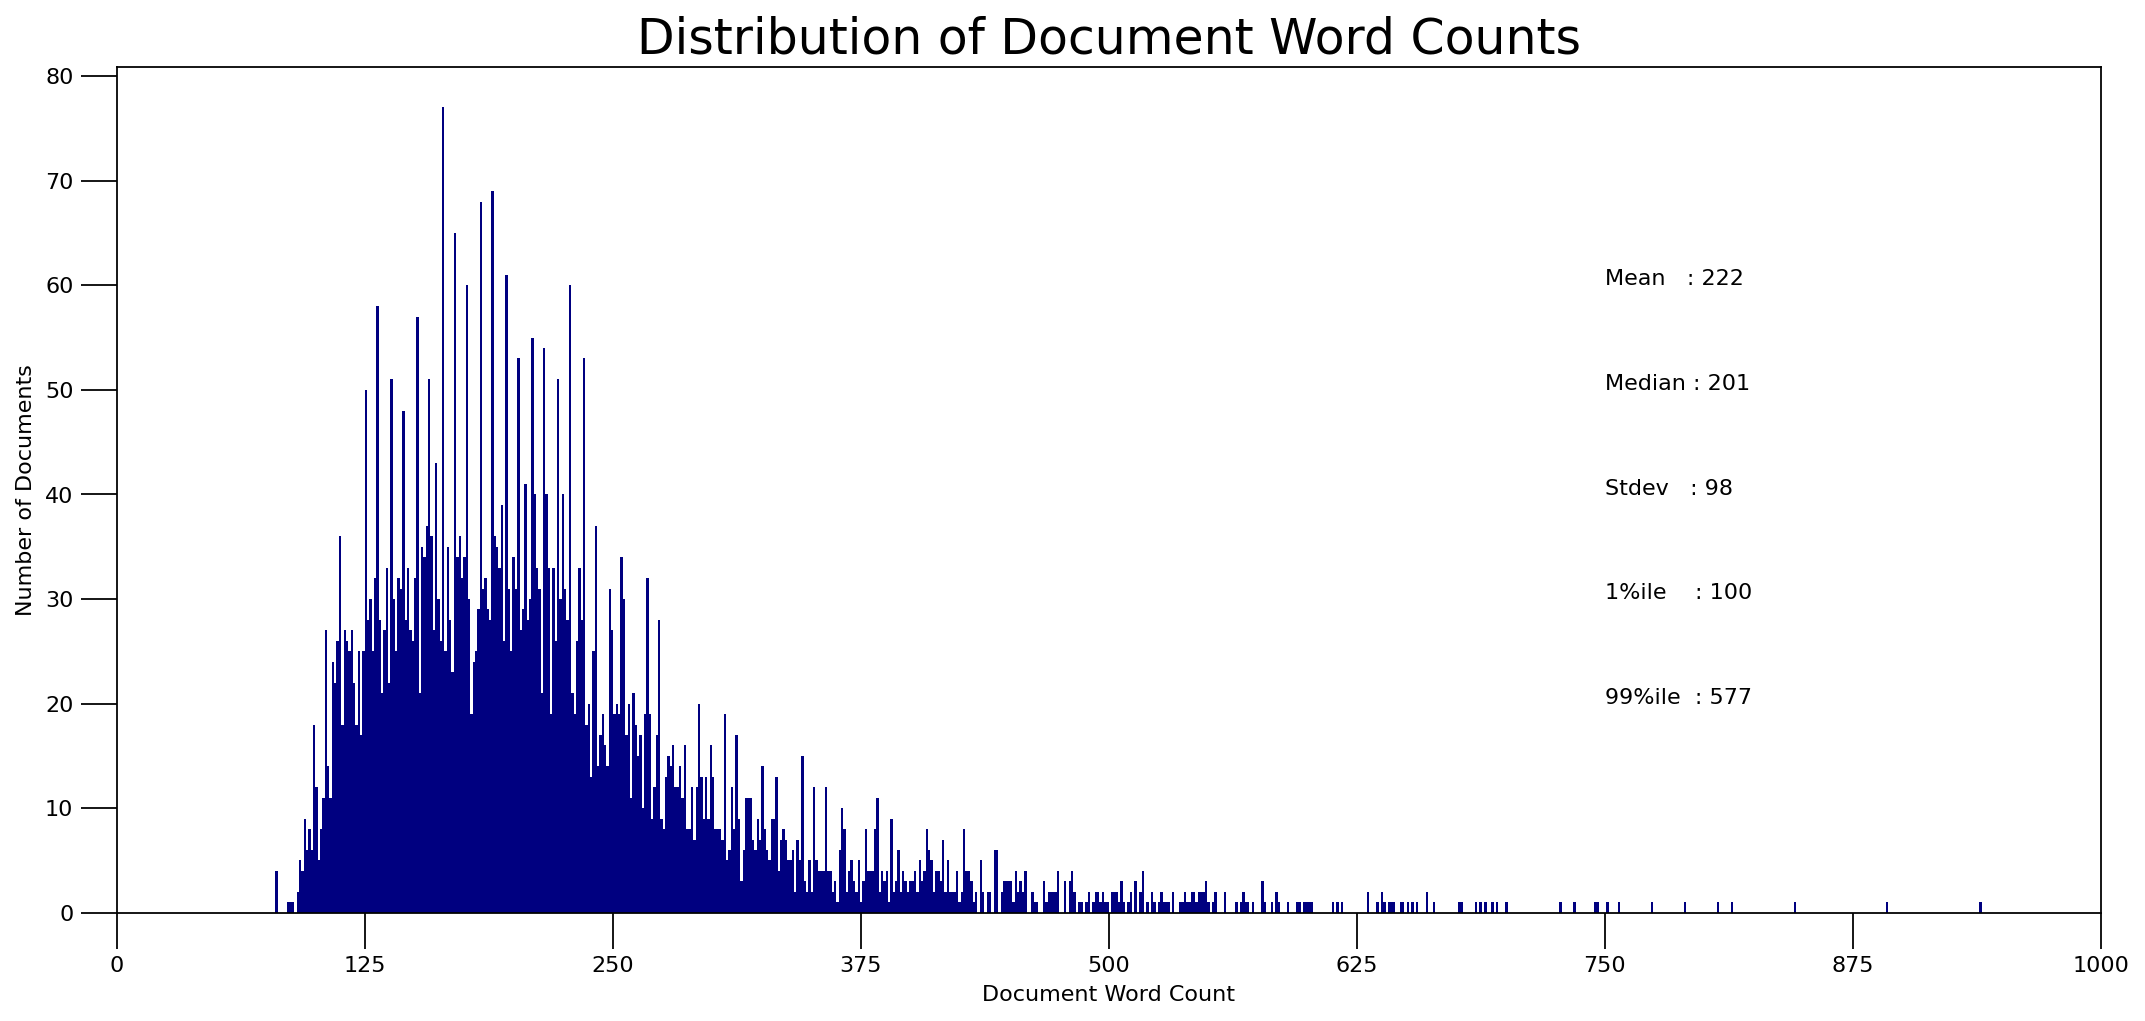

In [11]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 60, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  50, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  40, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  30, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  20, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

## 8.2

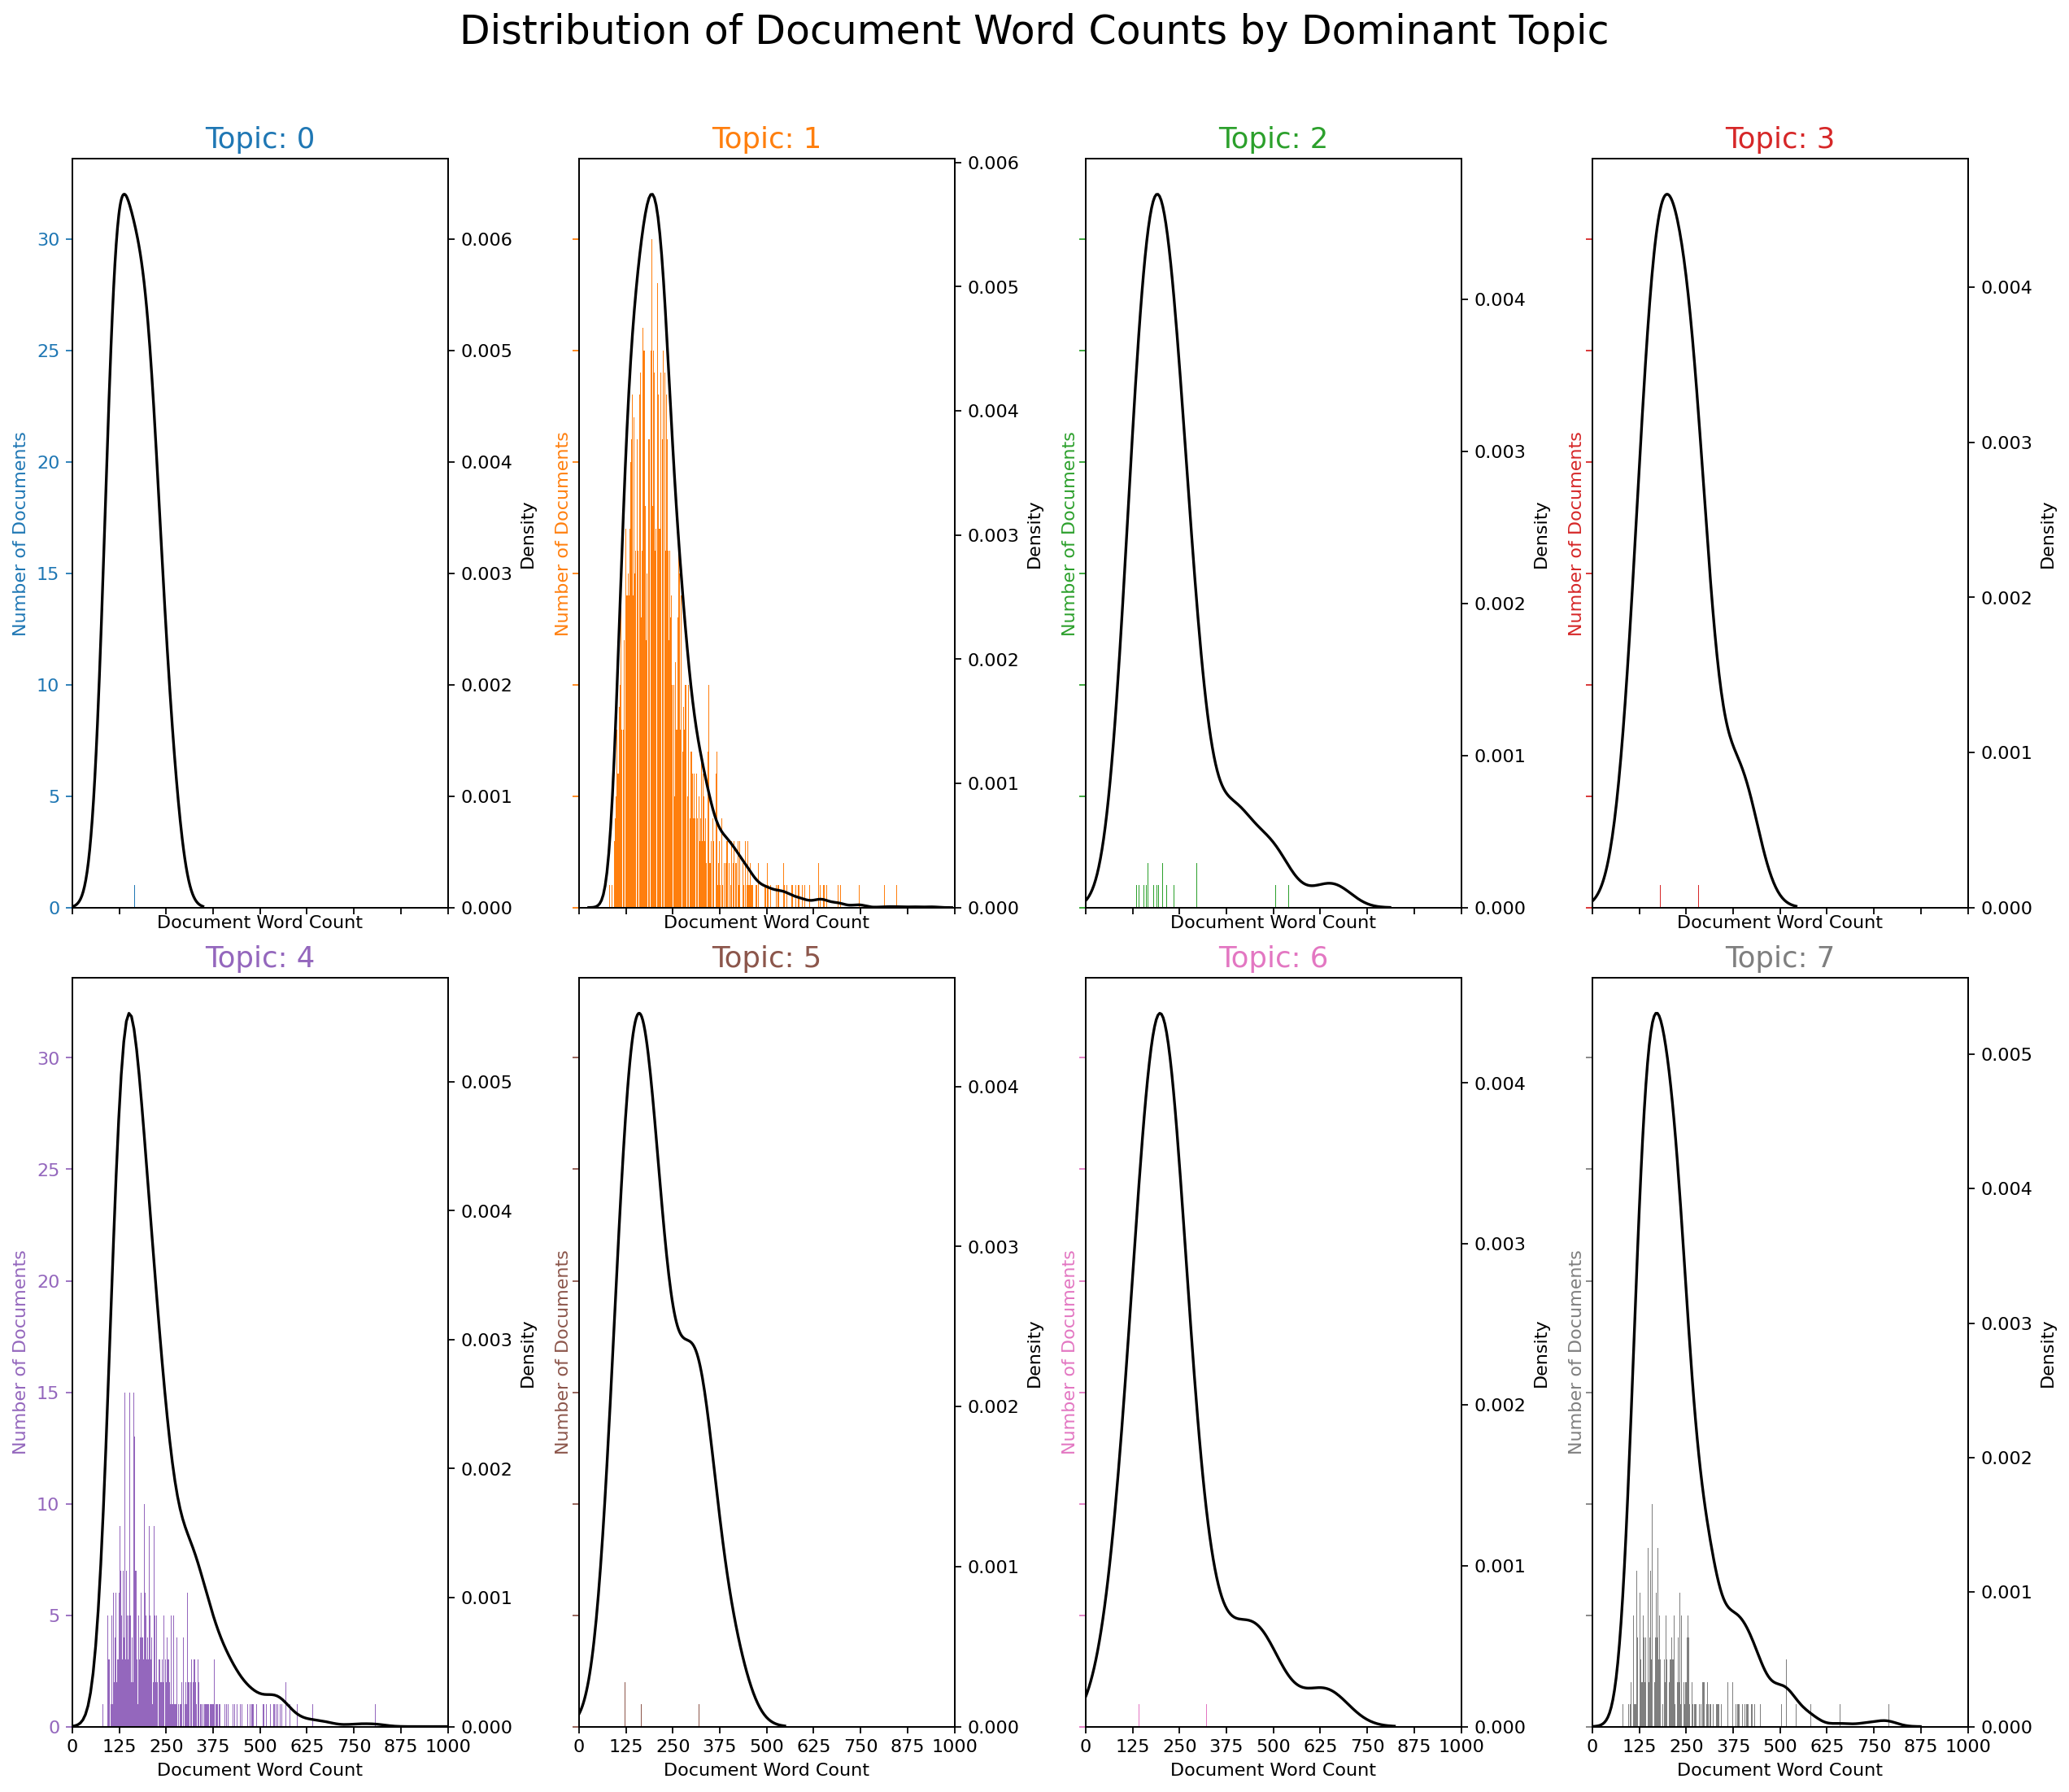

In [12]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

#use plt.subplots(2, 3,figsize=(16,14), dpi=160, sharex=True, sharey=True) for 6 topics
fig, axes = plt.subplots(2, 4,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

# 9 Word Clouds of Top N Keywords in Each Topic
Though you’ve already seen what are the topic keywords in each topic, a word cloud with the size of the words proportional to the weight is a pleasant sight. The coloring of the topics I’ve taken here is followed in the subsequent plots as well.

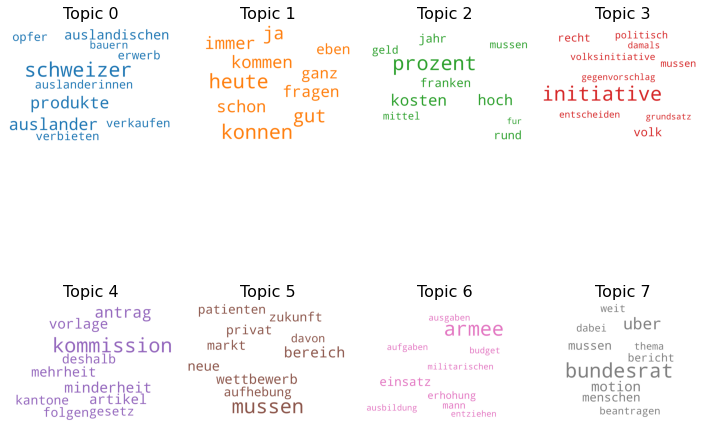

In [13]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

#use plt.subplots(2, 3, figsize=(10,10), sharex=True, sharey=True) for 6 topics
fig, axes = plt.subplots(2, 4, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# 10 Word Counts of Topic Keywords
When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.

Let’s plot the word counts and the weights of each keyword in the same chart.

You want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight. Often such words turn out to be less important. The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and re-running the training process.

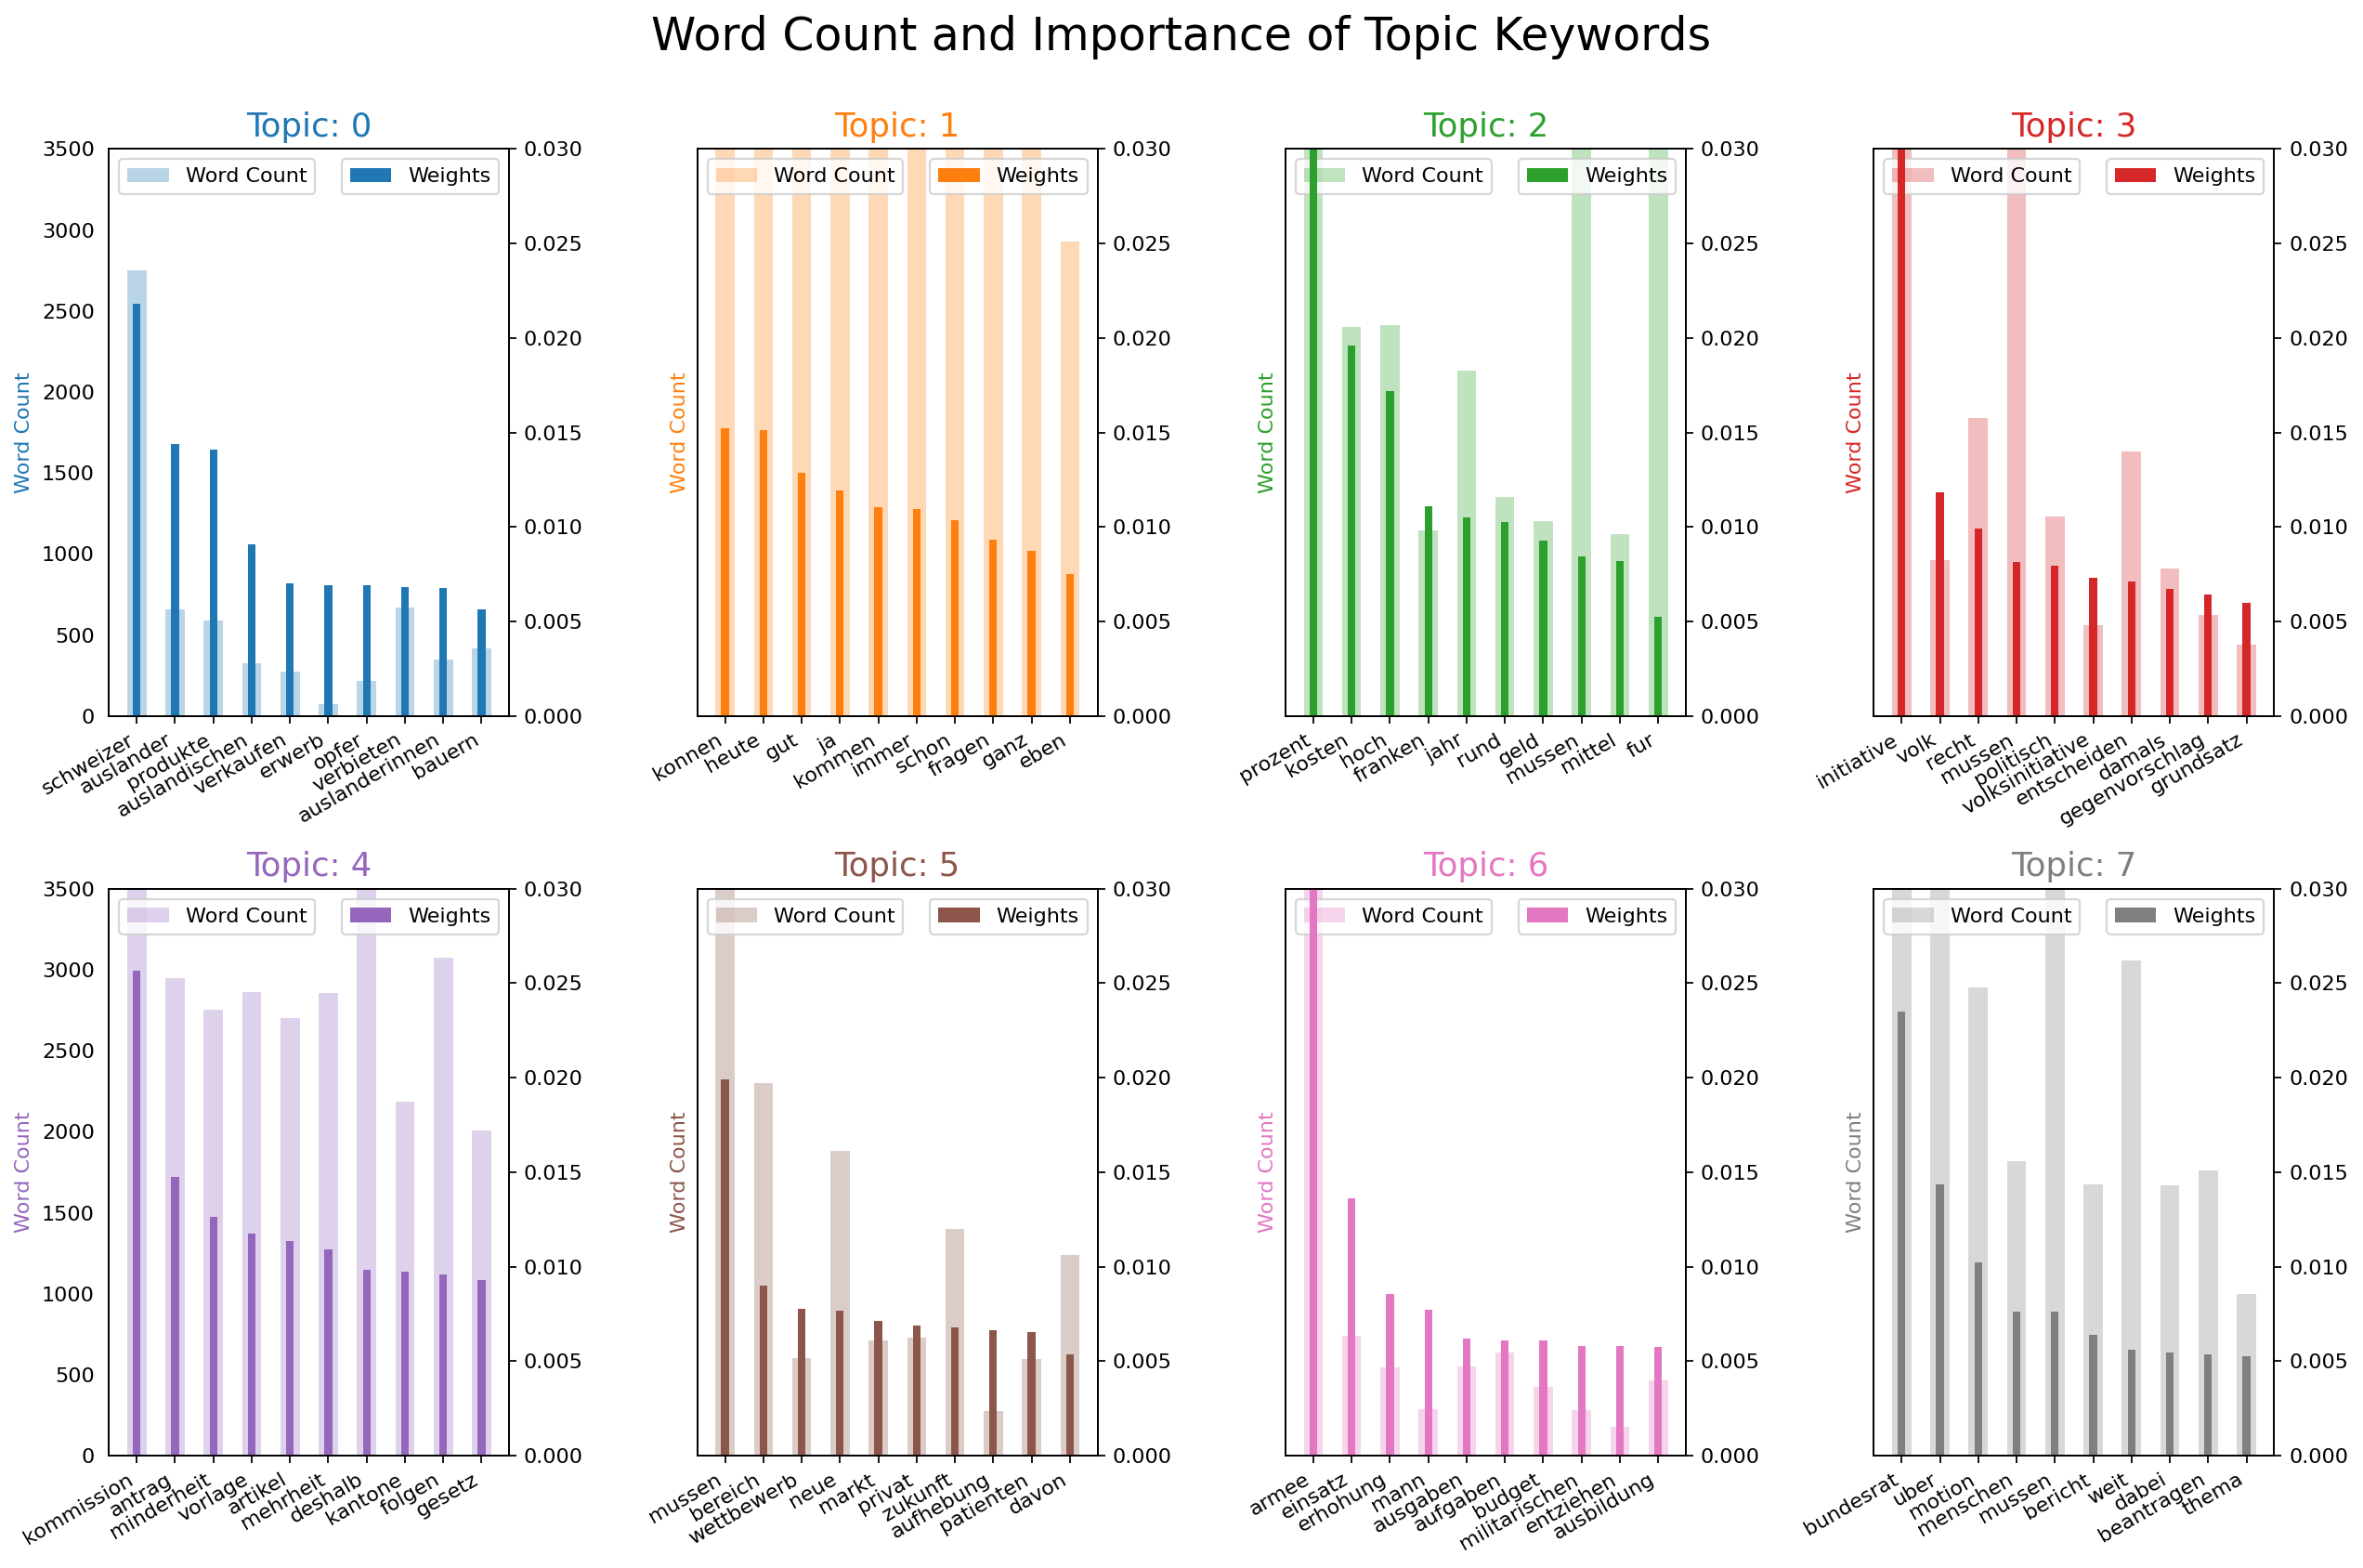

In [14]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
#use plt.subplots(2, 3, figsize=(16,10), sharey=True, dpi=160) for 6 topics
fig, axes = plt.subplots(2, 4, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

# 11 Sentence Chart Colored by Topic
Each word in the document is representative of one of the 4 topics. Let’s color each word in the given documents by the topic id it is attributed to.
The color of the enclosing rectangle is the topic assigned to the document.

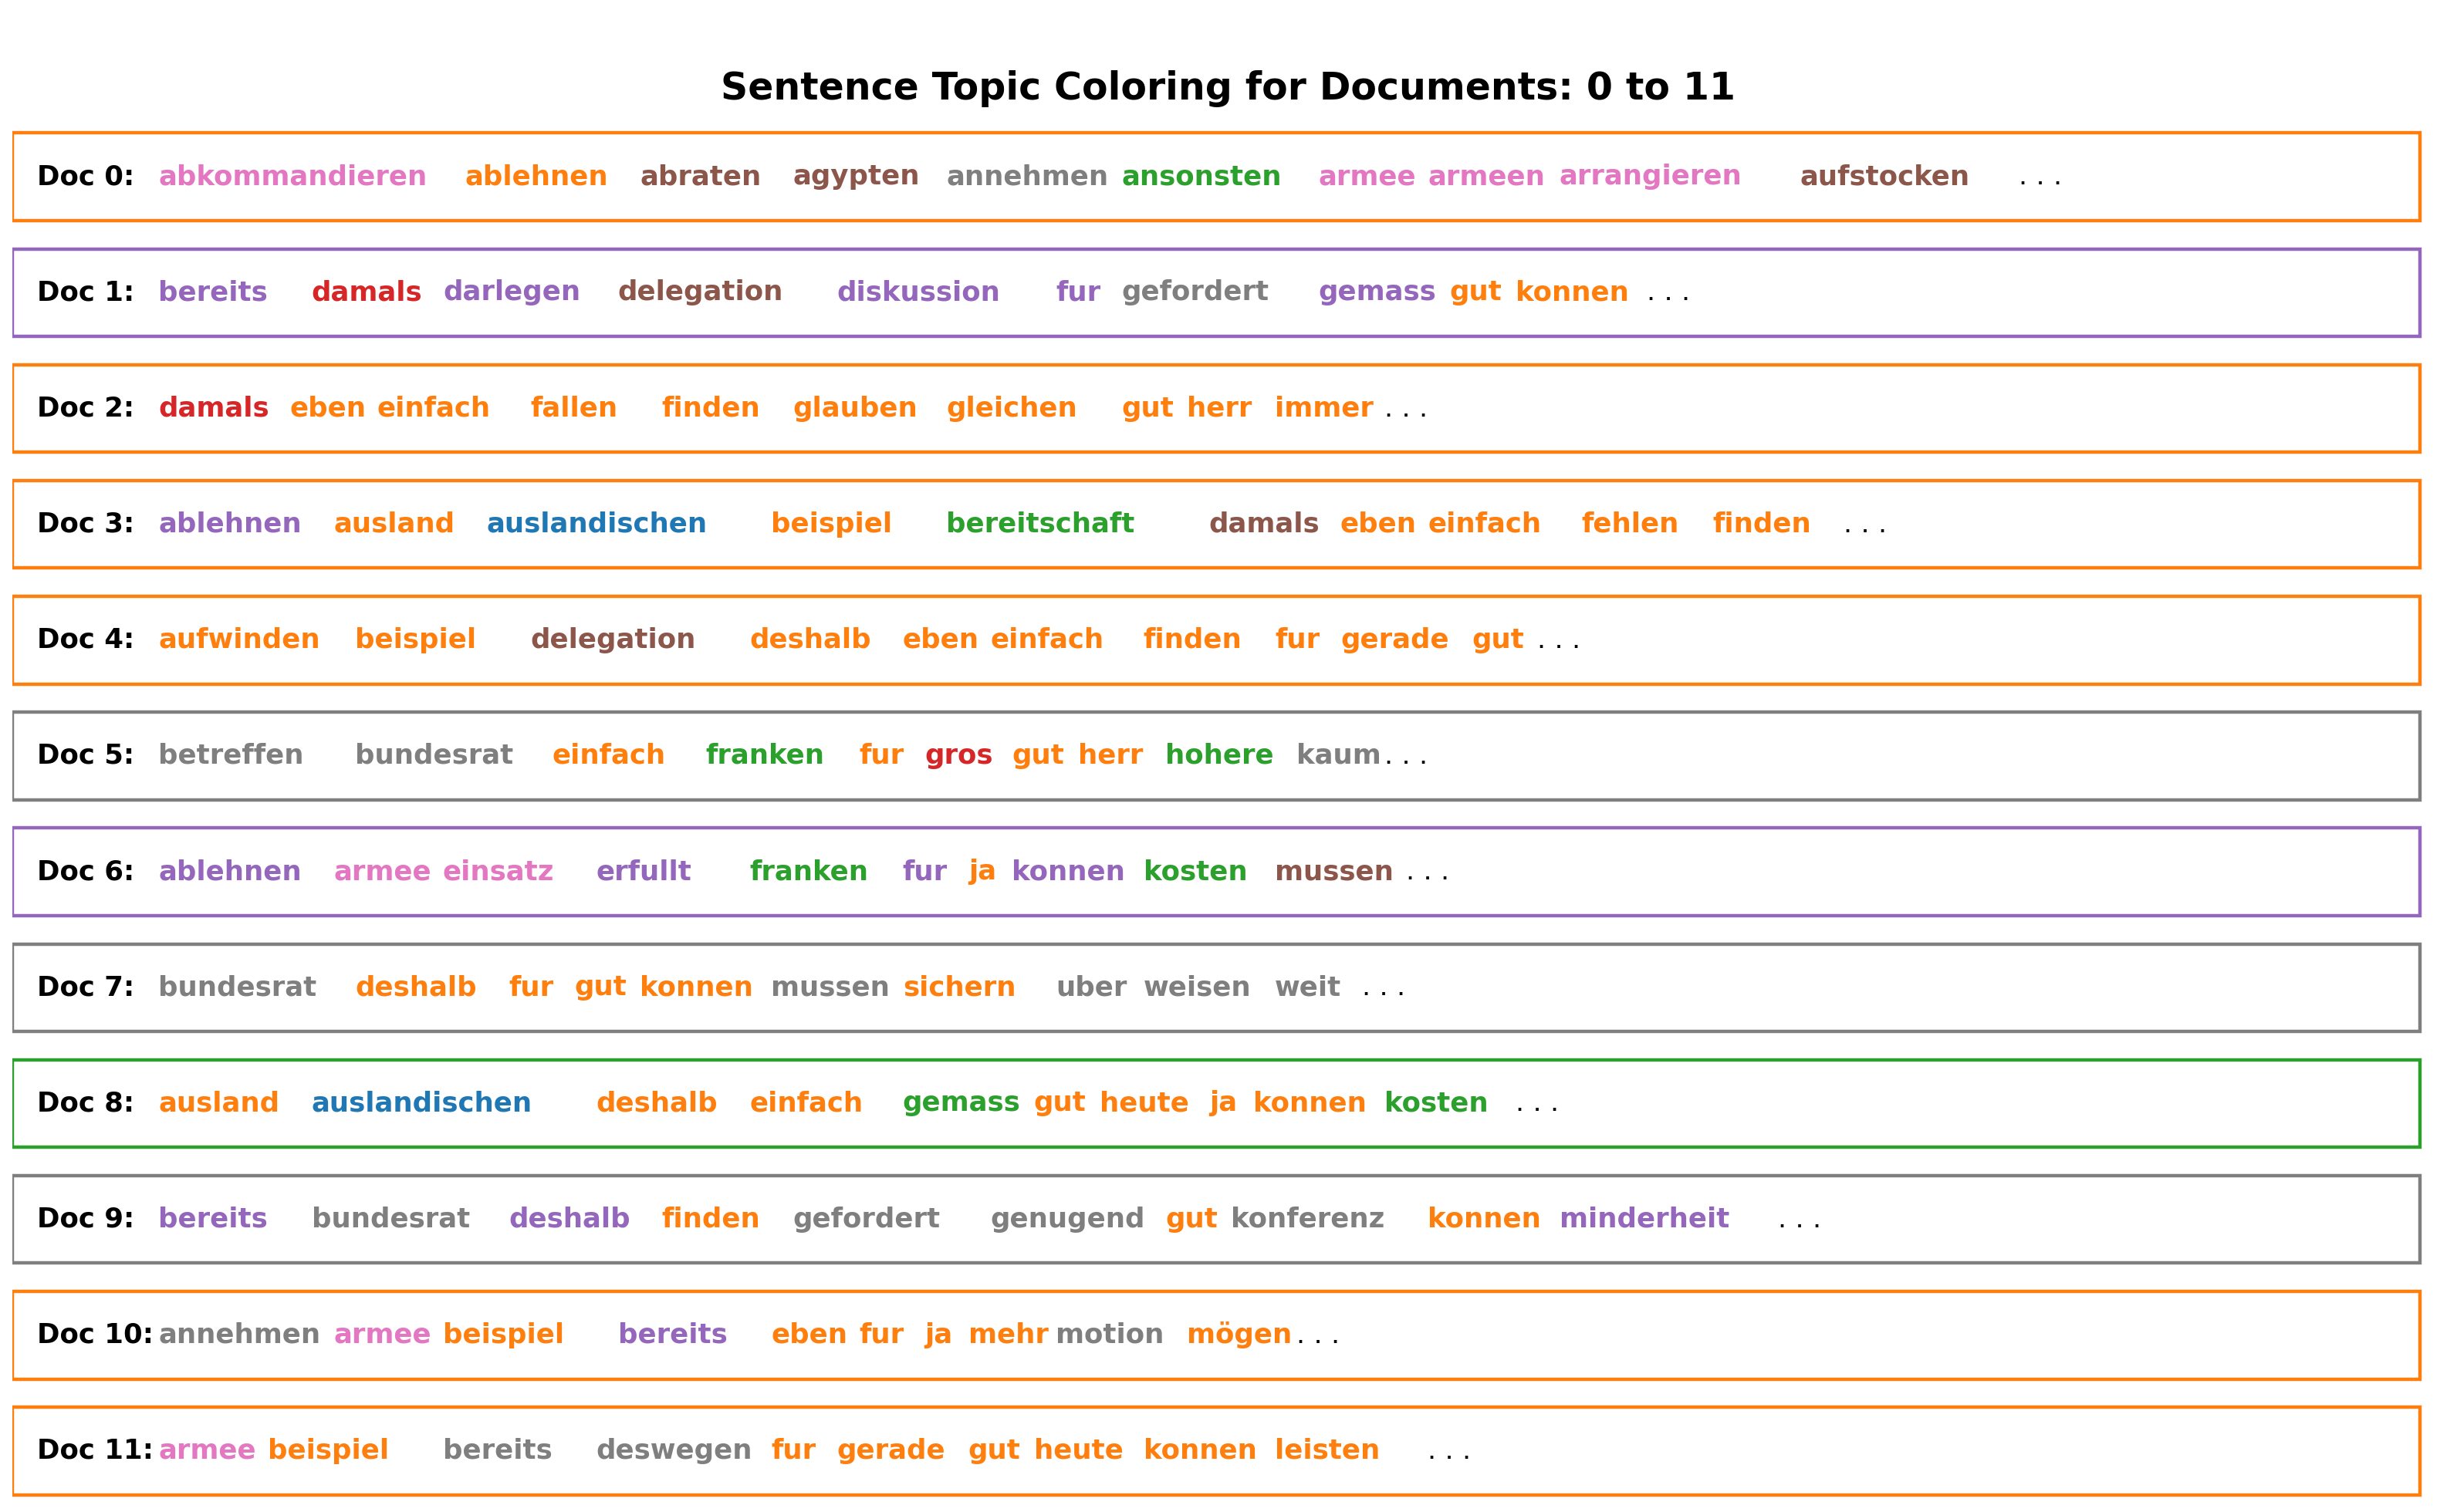

In [15]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 10:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

# 12 What are the most discussed topics in the documents?
Let’s compute the total number of documents attributed to each topic.

In [16]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

### Let’s make two plots:

The number of documents for each topic by assigning the document to the topic that has the most weight in that document.
The number of documents for each topic by by summing up the actual weight contribution of each topic to respective documents.

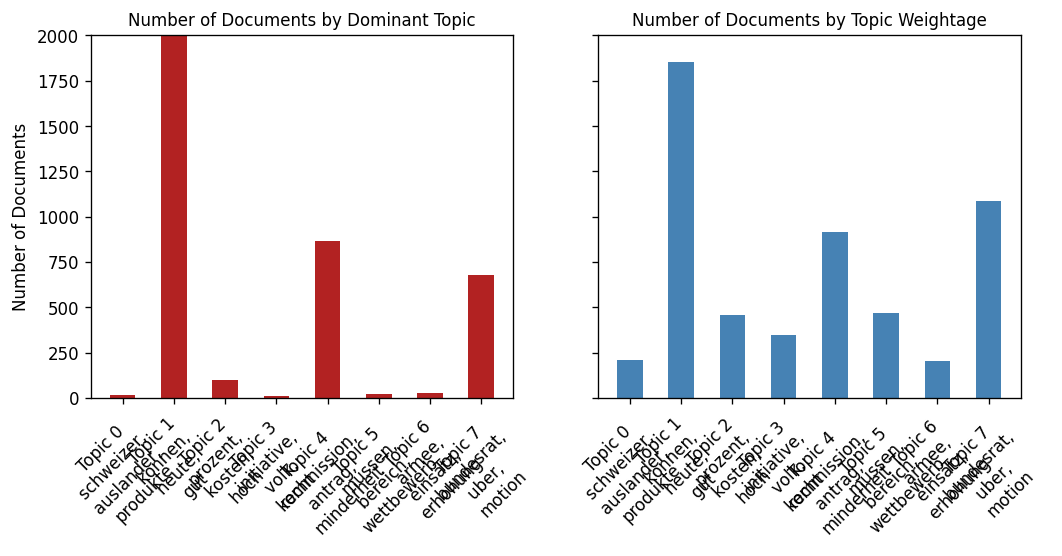

In [17]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 2000)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

plt.show()

# 13 t-SNE Clustering Chart
Let’s visualize the clusters of documents in a 2D space using t-SNE (t-distributed stochastic neighbor embedding) algorithm.

In [18]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 8
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3147 samples in 0.004s...
[t-SNE] Computed neighbors for 3147 samples in 0.176s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3147
[t-SNE] Computed conditional probabilities for sample 2000 / 3147
[t-SNE] Computed conditional probabilities for sample 3000 / 3147
[t-SNE] Computed conditional probabilities for sample 3147 / 3147
[t-SNE] Mean sigma: 0.058468
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.900826
[t-SNE] KL divergence after 1000 iterations: 1.172618


# 14

In [19]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7MB 21.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.3MB 314kB/s 
     |████████████████████████████████| 9.9MB 35.8MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-cp37-none-any.whl size=136870 sha256=bd531c732366d2fc823691f7fcc684b983acb3da62642b114c43e901b9747cd6
  Stored in directory: /root/.cache/pip/wheels/a0/9c/fc/c6e00689d35c82cf96a8adc70edfe7ba7904374fdac3240ac2
Successfully built pyLDAvis
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.2 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.2.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 

In [20]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.301210  0.122106       1        1  33.170807
7      0.118443 -0.230570       2        1  19.657285
4      0.238284  0.056910       3        1  16.246400
5     -0.143208 -0.200801       4        1   8.533583
2     -0.033177 -0.070633       5        1   8.343451
3     -0.147808  0.000451       6        1   6.443532
0     -0.178114  0.172022       7        1   3.812610
6     -0.155629  0.150515       8        1   3.792331, topic_info=            Term         Freq        Total Category  logprob  loglift
334   initiative  4956.000000  4956.000000  Default  30.0000  30.0000
339   kommission  5156.000000  5156.000000  Default  29.0000  29.0000
6          armee  2734.000000  2734.000000  Default  28.0000  28.0000
818      prozent  3692.000000  3692.000000  Default  27.0000  27.0000
33     bundesrat  7106.000000  7106.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
127      leisten   234.753581  1345.132649   Topic8  -5.2970   1.5265
5425      reform   171.851901   362.324023   Topic8  -5.6089   2.5263
55     einsetzen   204.062165   857.626770   Topic8  -5.4371   1.8364
1189     zukunft   163.194107  1126.153853   Topic8  -5.6606   1.3406
1567      landes   157.794044   668.159580   Topic8  -5.6942   1.8290

[418 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
1         1  0.344371        ablehnen
1         3  0.655508        ablehnen
234       3  0.381929       ablehnung
234       6  0.615451       ablehnung
2416      4  0.998047          absatz
...     ...       ...             ...
911       2  0.999428  zusammenarbeit
912       2  0.654382    zusammenhang
912       3  0.344329    zusammenhang
1097      2  0.998440     zusatzliche
1263      2  0.998530         zwingen

[558 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 8, 5, 6, 3, 4, 1, 7])